In [148]:
%matplotlib widget

import xarray as xr
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import datetime
from eomaps import Maps

In [149]:
sig0_dc = xr.open_dataset('data/s1_parameters/S1_CSAR_IWGRDH/SIG0/V1M1R1/EQUI7_EU020M/E054N006T3/SIG0_20180228T043908__VV_D080_E054N006T3_EU020M_V1M1R1_S1AIWGRDH_TUWIEN.nc')
hparam_dc = xr.open_dataset('data/tuw_s1_harpar/S1_CSAR_IWGRDH/SIG0-HPAR/V0M2R3/EQUI7_EU020M/E054N006T3/D080.nc')
plia_dc = xr.open_dataset('data/s1_parameters/S1_CSAR_IWGRDH/PLIA-TAG/V01R03/EQUI7_EU020M/E054N006T3/PLIA-TAG-MEAN_20200101T000000_20201231T235959__D080_E054N006T3_EU020M_V01R03_S1IWGRDH.nc')
RANGE = np.arange(-30, 0, 0.1)

In [150]:

sig0_dc['id'] = (('y', 'x'), np.arange(sig0_dc.SIG0.size).reshape(sig0_dc.SIG0.shape))
hparam_dc['id'] = (('y', 'x'), np.arange(sig0_dc.SIG0.size).reshape(sig0_dc.SIG0.shape))
plia_dc['id'] = (('y', 'x'), np.arange(sig0_dc.SIG0.size).reshape(sig0_dc.SIG0.shape))


In [151]:
def calc_water_prior(id):
    point = plia_dc.where(plia_dc.id == id, drop=True)
    wbsc_mean = point.PLIA * -0.394181 + -4.142015
    wbsc_std = 2.754041
    return norm.pdf(RANGE, wbsc_mean.to_numpy(), wbsc_std).flatten()


In [152]:
def expected_land_backscatter(data, dtime_str):
    w = np.pi * 2 / 365
    dt = datetime.datetime.strptime(dtime_str, "%Y-%m-%d")
    t = dt.timetuple().tm_yday
    wt = w * t

    M0 = data.M0
    S1 = data.S1
    S2 = data.S2
    S3 = data.S3
    C1 = data.C1
    C2 = data.C2
    C3 = data.C3
    hm_c1 = (M0 + S1 * np.sin(wt)) + (C1 * np.cos(wt))
    hm_c2 = ((hm_c1 + S2 * np.sin(2 * wt)) + C2 * np.cos(2 * wt))
    hm_c3 = ((hm_c2 + S3 * np.sin(3 * wt)) + C3 * np.cos(3 * wt))
    return hm_c3

def calc_land_prior(id):
    point = hparam_dc.where(hparam_dc.id == id, drop=True)
    lbsc_mean = expected_land_backscatter(point, '2018-02-01')
    lbsc_std = point.STD
    return norm.pdf(RANGE, lbsc_mean.to_numpy(), lbsc_std.to_numpy()).flatten()

def calc_priors(id):
    return calc_water_prior(id=id), calc_land_prior(id=id)

def plot_priors(id):
    point = sig0_dc.where(sig0_dc.id == id, drop=True).SIG0.to_numpy()
    y1_pdf, y2_pdf = calc_priors(id=id)
    fig, ax = plt.subplots(1, 1)
    ax.plot(RANGE, y1_pdf, 'k-', lw=2)
    ax.vlines(x=point, ymin=0, ymax=np.max((y1_pdf, y2_pdf)), lw=3)
    ax.plot(RANGE, y2_pdf,'r-', lw=5, alpha=0.6)

/tmp/ipykernel_28277/4061811920.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1)


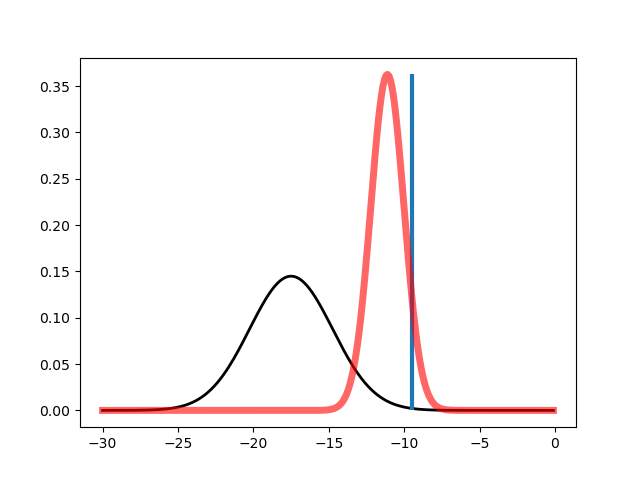

In [153]:
plot_priors(1)

In [154]:
def calc_posteriors(water_prior, land_prior):
    evidence = (water_prior * 0.5) + (land_prior * 0.5)
    return (water_prior * 0.5) / evidence,  (land_prior * 0.5) / evidence

def plot_posteriors(id):
    point = sig0_dc.where(sig0_dc.id == id, drop=True).SIG0.to_numpy()
    f_post, nf_post = calc_posteriors(*calc_priors(id=id))
    fig, ax = plt.subplots(1, 1)
    ax.plot(RANGE, f_post, 'k-', lw=2)
    ax.vlines(x=point, ymin=-0.1, ymax=1.1, lw=3)
    ax.plot(RANGE, nf_post,'r-', lw=5, alpha=0.6)

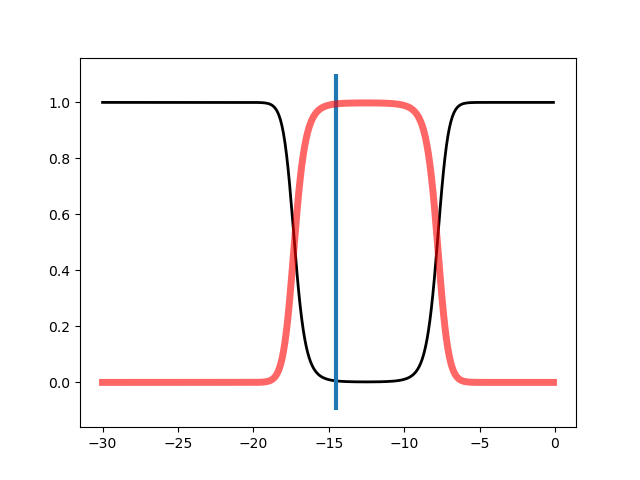

In [155]:
plot_posteriors(15)

In [156]:
# initialize a map on top
m = Maps(ax=211)
m.add_feature.preset.ocean()
m.add_feature.preset.coastline()

# initialize 2 matplotlib plot-axes below the map
ax_left = m.f.add_subplot(223)
ax_left.set_ylabel("density probability")
ax_left.set_xlabel("sigma")

ax_right = m.f.add_subplot(224)
ax_right.set_ylabel("probability")
ax_right.set_xlabel("sigma")

ax_left.sharey(ax_right)

# -------- assign data to the map and plot it
m.set_data(data=sig0_dc, x="x", y="y", parameter="SIG0", crs=sig0_dc.spatial_ref.crs_wkt)
# m.set_shape.shade_points()
m.plot_map()


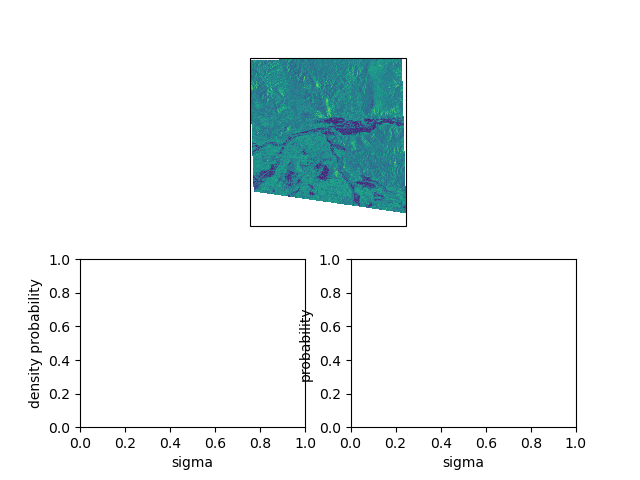

In [157]:
# -------- define a custom callback function to update the plots
def update_plots(ID, **kwargs):
    
    # get the data
    value = kwargs["val"]
    y1_pdf, y2_pdf = calc_priors(ID)
    f_post, nf_post = calc_posteriors(*calc_priors(id=id))

    # plot the lines and vline
    (water,) = ax_left.plot(RANGE, y1_pdf, 'k-', lw=2)
    (land,) = ax_left.plot(RANGE, y2_pdf,'r-', lw=5, alpha=0.6)
    value_left = ax_left.vlines(x=value, ymin=0, ymax=np.max((y1_pdf, y2_pdf)), lw=3)

    (nf,) = ax_right.plot(RANGE, f_post, 'k-', lw=2)
    (f,) = ax_right.plot(RANGE, nf_post,'r-', lw=5, alpha=0.6)
    value_right = ax_right.vlines(x=value, ymin=-0.1, ymax=1.1, lw=3)
    

    # re-compute axis limits based on the new artists
    ax_left.relim()
    ax_right.relim()
    ax_left.autoscale()
    ax_right.autoscale()

    # add all artists as "temporary pick artists" so that they
    # are removed when the next datapoint is selected
    for a in [water, land, value_right, nf, f, value_left]:
        m.cb.pick.add_temporary_artist(a)

m.cb.pick.attach(update_plots)
m.cb.pick.attach.annotate()
m.cb.pick.attach.mark(permanent=False, buffer=1, fc="none", ec="r")
m.cb.pick.attach.mark(permanent=False, buffer=2, fc="none", ec="r", ls=":")
m.show()